In [1]:
import pandas as pd
df = pd.read_csv("./Data/HilbertSortedPOIs.csv")
print(df)
TOTAL = len(df)+1
COL = df.columns

# maybe I should substract the mean of hilbert: not performance gain
# print(df.iloc[:,4].mean())
# df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,4].mean()
# print(df)

# maybe I should divide the variance of hilbert? 
df.iloc[:,4] = df.iloc[:,4] / df.iloc[:,4].var()
print(df)

# 用GAN 来做类似Rtree？

                x        y       x_       y_        hilbert    order  \
0        15.24060  32.4770  2104812  2124770      387885300        0   
1        15.55460  32.5908  2111092  2125908      437528096        1   
2        15.60510  32.6348  2112102  2126348      451057380        2   
3        15.59940  32.5877  2111988  2125877      451672609        3   
4        15.60170  32.5865  2112034  2125865      451676231        4   
5        15.60190  32.5874  2112038  2125874      451677074        5   
6        15.61570  32.6319  2112314  2126319      451828539        6   
7        15.65180  32.5395  2113036  2125395      453161461        7   
8        15.63280  32.5325  2112656  2125325      453428057        8   
9        15.64080  32.5314  2112816  2125314      453447428        9   
10       15.64590  32.5313  2112918  2125313      453503767       10   
11       15.64210  32.4882  2112842  2124882      453714402       11   
12       15.64080  32.4881  2112816  2124881      453719209     

In [2]:
import numpy as np
print(np.any(np.isnan(df))) # should be false
print(np.all(np.isfinite(df))) # should be true
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
print(scaler.fit(df.iloc[:,0:5]))
print(scaler.mean_)
df.iloc[:,0:5]=scaler.transform(df.iloc[:,0:5])
print(df)
# print(df)

True
False
StandardScaler(copy=True, with_mean=True, with_std=True)
[  2.04740792e+01   8.85068347e+00   2.20948145e+06   1.88850673e+06
   1.52127265e-12]
                x         y        x_        y_   hilbert    order  prediction
0       -0.206655  0.278680 -0.206655  0.278680 -1.661982        0         NaN
1       -0.194256  0.280023 -0.194256  0.280023 -1.661937        1         NaN
2       -0.192262  0.280542 -0.192262  0.280542 -1.661924        2         NaN
3       -0.192487  0.279986 -0.192487  0.279986 -1.661924        3         NaN
4       -0.192396  0.279972 -0.192396  0.279972 -1.661924        4         NaN
5       -0.192388  0.279982 -0.192388  0.279983 -1.661924        5         NaN
6       -0.191843  0.280507 -0.191843  0.280507 -1.661924        6         NaN
7       -0.190418  0.279417 -0.190417  0.279418 -1.661923        7         NaN
8       -0.191168  0.279335 -0.191168  0.279335 -1.661922        8         NaN
9       -0.190852  0.279322 -0.190852  0.279322 -1.661

In [3]:
from sklearn import linear_model
from sklearn import ensemble
import ipdb
import time
stages = [1,10,100]
index = []
data = []

start_time=time.time()

for i in range(len(stages)):
    temp = []
    for j in range(stages[i]):
        df_ = pd.DataFrame(columns=COL)
        temp.append(df_)
    data.append(temp)
    
data[0][0] = df
nodatacount = 0

for i in range(len(stages)):
    temp = []
    print("======stage:"+str(i)+"======")
    
    for j in range(stages[i]):
        print("model:"+str(j))
        if len(data[i][j]) == 0:
            nodatacount += 1
            data[i][j] = data[i][j-1]
            print(j)
#         lr = linear_model.LinearRegression()
#         lr = linear_model.ElasticNet(max_iter=10000)
#         lr = linear_model.Lasso(max_iter=10000)
        lr = ensemble.GradientBoostingRegressor()
#         train_x = data[i][j].iloc[:,4].reshape(-1,1)
        train_x = data[i][j].iloc[:,0:5]
        train_y = data[i][j].iloc[:,5]
        lr.fit(train_x,train_y)
        temp.append(lr)
        # allocate data
        if i < len(stages)-1:
            predicted = lr.predict(train_x)
            for pi in range(len(predicted)): # do not change the prediction
                #print(item)
                if predicted[pi] < 0:
                    predicted[pi] = 0
                if predicted[pi] >= TOTAL:
                    predicted[pi] = TOTAL-1   
            ModelID = ((predicted/TOTAL)*stages[i+1]).astype(int)
            data[i][j].iloc[:,-1]=ModelID
#             if i == 1 and np.any(data[i][j]['prediction'] == 4):
#                 print(j)

            for k in range(stages[i+1]):
                data[i+1][k] = data[i+1][k].append(data[i][j].loc[data[i][j]['prediction'] == k])
    index.append(temp)

elapsed_time = time.time() - start_time
print(elapsed_time)
print(nodatacount)

======stage:0======
model:0
======stage:1======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
======stage:2======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
model:10
model:11
model:12
model:13
model:14
model:15
model:16
model:17
model:18
model:19
model:20
model:21
model:22
model:23
model:24
model:25
model:26
model:27
model:28
model:29
model:30
model:31
model:32
model:33
model:34
model:35
model:36
model:37
model:38
model:39
model:40
model:41
model:42
model:43
model:44
model:45
model:46
model:47
model:48
model:49
model:50
model:51
model:52
model:53
model:54
model:55
model:56
model:57
model:58
model:59
model:60
model:61
model:62
model:63
model:64
model:65
model:66
model:67
model:68
model:69
model:70
model:71
model:72
model:73
model:74
model:75
model:76
model:77
model:78
model:79
model:80
model:81
model:82
model:83
model:84
model:85
model:86
model:87
model:88
model:89
model:90
model:91
model:92
model:93
model:94
model:9

In [4]:
import numpy as np
# use the generated stage index for prediction
def predict_with_stage_model(model, data):
    totalSize = len(data)+1
    predicted_y = []
    tempy = 0
    for i in range(len(data)):
        modelIndex = 0
        for m in range(len(model)):
            tempy = model[m][modelIndex].predict(data.iloc[i,:].reshape(1,-1))
#             tempy = model[m][modelIndex].predict(data.iloc[i,])
            if tempy < 0:
                tempy = 0
            if tempy >= totalSize:
                tempy = totalSize-1
            if m < len(model)-1:
                modelIndex = int((tempy/totalSize)*len(model[m+1]))
                
        predicted_y.append(tempy)
        
    return predicted_y

D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


544.3879616260529


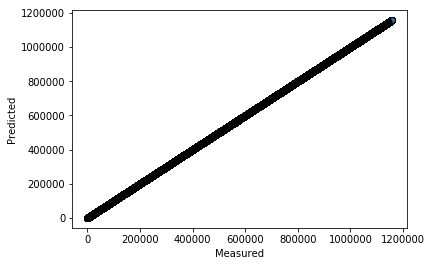

In [5]:
import matplotlib.pyplot as plt
import time

train_x=df.iloc[:,0:5]
# train_x=df.iloc[:,4]
train_y=df.iloc[:,5]

start_time=time.time()
predicted_y = predict_with_stage_model(index, train_x)
elapsed_time = time.time() - start_time
print(elapsed_time)

fig, ax = plt.subplots()
ax.scatter(train_y, predicted_y, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [6]:
# estimate the result
from sklearn.metrics import explained_variance_score
train_y=df.iloc[:,5]
print(len(train_y))
print(len(predicted_y))

# 1- Var(Ytrue - Ypred)/Var(Ytrue)  best: 1  the lower the worse
result = explained_variance_score(train_y, predicted_y)
print(result)# calculate scan item amount

ind = 0
scan = 0
totalscan = 0
for i in range(len(df)):
    ind = predicted_y[i]
    scan = abs(ind-i) # distance to exact
    totalscan += scan

print(totalscan/len(df))

1157570
1157570
0.999999861748
[ 78.34372394]
